# CNN
## Introduction

This notebook is an attempt to repurpose and finetune an EfficientNet model to the task of American Sign Language detection for the DSPRO2 project at HSLU.

## Setup
In this section all the necessary libraries are imported.

In [1]:
%pip install multidict==6.0.4
%pip install fiftyone
%pip install kornia

  Using cached multidict-6.0.4-cp312-cp312-linux_x86_64.whl
  Attempting uninstall: multidict
    Found existing installation: multidict 6.3.2
    Uninstalling multidict-6.3.2:
      Successfully uninstalled multidict-6.3.2
Note: you may need to restart the kernel to use updated packages.
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.13.2-py3-none-any.whl (45 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.13.1
    Uninstalling typing_extensions-4.13.1:
      Successfully uninstalled typing_extensions-4.13.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade --force-reinstall -r requirements.txt

  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiohttp-3.11.16-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached asttokens-3.0.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached debugpy-1.8.13-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached decorator-5.2.

In [3]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
import wandb
import torch
import torch.nn as nn
import torchvision.models as visionmodels
import torchvision.transforms.v2 as transforms
import lightning as L

from lightning.pytorch.loggers import WandbLogger

import nbformat

from typing import Callable

import os

# from own classes
import models.sweep_helper as sweep_helper

from datapipeline.asl_image_data_module import ASLImageDataModule
from datapipeline.asl_kaggle_image_data_module import ASLKaggleImageDataModule, DEFAULT_TRANSFORMS
from datapipeline.asl_transforms import ExtractHand, RandomBackgroundNoise, RandomRealLifeBackground
from models.asl_model import ASLModel
from models.training import sweep, train_model

In [7]:
os.environ["WANDB_NOTEBOOK_NAME"] = "cnn.ipynb"

## Preprocessing
No general data preprocessing is necessary, however there will be random transforms applied to the images during training. The images are resized to 224x224 pixels, which is the input size of the EfficientNet model. The images are also normalized using the mean and standard deviation of the ImageNet dataset, which is the dataset on which the EfficientNet model was pretrained.

The following cells will show the loading of the dataset and the preparation of the mentioned transforms.

In [8]:
PATH = "/exchange/dspro2/silent-speech/ASL_Pictures_Dataset"
PATH = r"C:\Temp\silent-speech"

In [9]:
datamodule = ASLKaggleImageDataModule(path=PATH, train_transforms=DEFAULT_TRANSFORMS.TRAIN, valid_transforms=DEFAULT_TRANSFORMS.VALID, test_transforms=DEFAULT_TRANSFORMS.TEST, batch_size=32, num_workers=20)

## Models

In [10]:
NUM_CLASSES = 28

In [11]:
class ASLCNN_fixed_layers(nn.Module):
    def __init__(self, kernel_size: int, dropout: float =0.2, hidden_dim: int =128, adaptive_pool_size: int =4):
        super().__init__()
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.hidden_dim = hidden_dim
        self.adaptive_pool_size = adaptive_pool_size
        self.model = nn.Sequential(
            # nn.Conv2d(input_channel, output) output can be chosen freely.
            nn.Conv2d(3, 32, kernel_size=self.kernel_size, stride=1, padding=1),
            nn.ReLU(),            
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=self.kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=self.kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.AdaptiveAvgPool2d((self.adaptive_pool_size, self.adaptive_pool_size)), # To prevent OOM
            nn.Flatten(),
            
            nn.LazyLinear(self.hidden_dim), # Automatic adaptation to output -"compression"
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_dim, NUM_CLASSES),
        )


    def forward(self, x):
        x = self.model(x)
        return x

    # TODO CHECK
    def get_main_params(self):
        yield from self.model.classifier.parameters()

    def get_finetune_params(self):
        yield from self.model.features.parameters()

## Training

In [12]:
def get_asl_cnn_model(kernel_size:int, dropout:float, hidden_dim:int, adaptive_pool_size:int):
    cnn_model = ASLCNN_fixed_layers(kernel_size=kernel_size, dropout=dropout, hidden_dim=hidden_dim, adaptive_pool_size=adaptive_pool_size)
    print('cnn_model instantiated')
    return cnn_model

def get_cnn_model_from_config(config: dict) -> nn.Module:
    cnn_model = get_asl_cnn_model(config[KERNEL_SIZE], config[DROPOUT], config[HIDDEN_DIM], config[ADAPTIVE_POOL_SIZE])
    print('cnn model from config returned')
    return cnn_model

In [13]:
run_id = 0
SEED = 42

def train_cnn():
    train_model("cnn_3layers", get_cnn_model_from_config, datamodule, get_optimizer=sweep_helper.get_optimizer, seed=SEED)

In [14]:
DROPOUT = "DROPOUT"
HIDDEN_DIM = "HIDDEN_DIM"
KERNEL_SIZE = "KERNEL_SIZE"
ADAPTIVE_POOL_SIZE = "adaptive_pool_size"

cnn_sweep_config = {
    "name": "cnn-fixed-layer",
    "method": "bayes",
    "metric": {
        "name": f"{ASLModel.VALID_ACCURACY}",
        "goal": "maximize"
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 5
    },
    "parameters": {
        KERNEL_SIZE: {
            "values": [3, 5]
        },
        DROPOUT: {
            "min": 0.1,
            "max": 0.5
        },
        HIDDEN_DIM: {
            "values": [64, 128, 256]
        },
        ADAPTIVE_POOL_SIZE: {
            "values": [2, 4, 8]
        },
        sweep_helper.OPTIMIZER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "values": [sweep_helper.OptimizerType.RMSPROP,
                              sweep_helper.OptimizerType.ADAMW,]
                },
                sweep_helper.LEARNING_RATE: {
                    "min": 1e-5,
                    "max": 1e-3,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.FINETUNE_LEARNING_RATE: {
                    "min": 1e-7,
                    "max": 1e-5,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.WEIGHT_DECAY: {
                    "min": 0,
                    "max": 1e-3,
                },
                sweep_helper.MOMENTUM: {
                    "min": 0.8,
                    "max": 0.99
                },
            }
        },
        sweep_helper.LEARNING_RATE_SCHEDULER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "values": [
                        sweep_helper.LearningRateSchedulerType.STEP,
                        sweep_helper.LearningRateSchedulerType.EXPONENTIAL
                    ]
                },
                sweep_helper.STEP_SIZE: {"value": 5},
                sweep_helper.GAMMA: {
                    "min": 0.1,
                    "max": 0.9
                }
            }
        }
    }
}


In [15]:
#Uncomment line below to start the sweep
sweep(sweep_config=cnn_sweep_config, count=10, training_procedure=train_cnn)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 800bsvpg
Sweep URL: https://wandb.ai/dspro2-silent-speech/silent-speech/sweeps/800bsvpg


wandb: Agent Starting Run: xdv8h0r7 with config:
wandb: 	DROPOUT: 0.24043039909819913
wandb: 	HIDDEN_DIM: 256
wandb: 	KERNEL_SIZE: 3
wandb: 	adaptive_pool_size: 2
wandb: 	learning_rate_scheduler: {'gamma': 0.7256988718894885, 'step_size': 5, 'type': 'step'}
wandb: 	optimizer: {'finetune_learning_rate': 5.180708195909077e-06, 'learning_rate': 0.00045185594152184815, 'momentum': 0.96735032028867, 'type': 'rmsprop', 'weight_decay': 0.0005085695022132184}
Seed set to 42
wandb: Currently logged in as: shse13 (dspro2-silent-speech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 100 K  | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.023
Metric train_accuracy improved. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.024


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 0.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇███████
lr-RMSprop,██████████████████████████████████▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▅▃█▃▃▁▆▁▆▅▅▃▁▁▅▁█▁▅▁▃▃▁▃▆▁▅▅▁▃▅▃▃▁▃▃▃▆▅
train_loss,▁▁▁▁▁█▁▁▃▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
valid_accuracy,▃▃▂▁█▂
valid_loss,█▂▁▂▁▁
epoch,5
lr-RMSprop,0.00033


wandb: Agent Starting Run: senhkypy with config:
wandb: 	DROPOUT: 0.36342487777125543
wandb: 	HIDDEN_DIM: 128
wandb: 	KERNEL_SIZE: 5
wandb: 	adaptive_pool_size: 4
wandb: 	learning_rate_scheduler: {'gamma': 0.5114434755546999, 'step_size': 5, 'type': 'exponential'}
wandb: 	optimizer: {'finetune_learning_rate': 3.364821460836698e-07, 'learning_rate': 0.00039456091157674217, 'momentum': 0.914969518047115, 'type': 'rmsprop', 'weight_decay': 0.0003047879270341326}
Seed set to 42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 262 K  | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.049     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.022
Metric train_accuracy improved. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.278 >= min_delta = 0.0. New best score: 0.306
Metric train_accuracy improved by 0.500 >= min_delta = 0.0. New best score: 0.500


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.204 >= min_delta = 0.0. New best score: 0.510


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.097 >= min_delta = 0.0. New best score: 0.607
Metric train_accuracy improved by 0.200 >= min_delta = 0.0. New best score: 0.700


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.052 >= min_delta = 0.0. New best score: 0.659
Metric train_accuracy improved by 0.100 >= min_delta = 0.0. New best score: 0.800


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.0. New best score: 0.689


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.700


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.710


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.714


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.717
Monitored metric train_accuracy did not improve in the last 5 records. Best score: 0.800. Signaling Trainer to stop.


epoch,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
lr-RMSprop,████▅▅▅▅▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▂▁▁▂▁▁▁▂▃▂▃▃▄▄▅▆▄▅▅▅▆▆▆▇▆▆▆▇▆▇▆▇▅▅▆█▇█▇▇
train_loss,███████████████▅▃▅▃▄▃▂▂▂▂▁▂▂▁▂▂▁▂▂▂▂▁▁▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
valid_accuracy,▁▁▄▆▇▇█████
valid_loss,██▅▃▂▂▁▁▁▁▁
epoch,10
lr-RMSprop,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pzzq72me with config:
wandb: 	DROPOUT: 0.32141303600493704
wandb: 	HIDDEN_DIM: 64
wandb: 	KERNEL_SIZE: 5
wandb: 	adaptive_pool_size: 2
wandb: 	learning_rate_scheduler: {'gamma': 0.634494844232927, 'step_size': 5, 'type': 'exponential'}
wandb: 	optimizer: {'finetune_learning_rate': 1.6613482197182315e-07, 'learning_rate': 9.189090668601331e-05, 'momentum': 0.9486771601521138, 'type': 'rmsprop', 'weight_decay': 0.0004749197467922787}
Seed set to 42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 260 K  | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.042     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.031
Metric train_accuracy improved. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.0. New best score: 0.074
Metric train_accuracy improved by 0.100 >= min_delta = 0.0. New best score: 0.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.261 >= min_delta = 0.0. New best score: 0.335
Metric train_accuracy improved by 0.200 >= min_delta = 0.0. New best score: 0.300


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.100 >= min_delta = 0.0. New best score: 0.435
Metric train_accuracy improved by 0.100 >= min_delta = 0.0. New best score: 0.400


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.122 >= min_delta = 0.0. New best score: 0.557
Metric train_accuracy improved by 0.400 >= min_delta = 0.0. New best score: 0.800


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.0. New best score: 0.595


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.0. New best score: 0.618


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.020 >= min_delta = 0.0. New best score: 0.638
Metric train_accuracy improved by 0.200 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.656


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.670


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.672
Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
lr-RMSprop,████▅▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▂▁▁▁▁▁▁▂▂▂▄▅▅▄▅▄▆▆▆▆▇▇▆█▆▇█▇▇▆▇▆▇▇▇▇▇█▇▇
train_loss,██████▇▆▆▆▃▄▄▄▃▅▂▂▂▂▄▂▁▂▂▂▂▁▂▁▂▃▂▁▂▁▂▂▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▇▇▇▇▇▇█
valid_accuracy,▁▁▄▅▇▇▇██████
valid_loss,██▅▃▂▂▁▁▁▁▁▁▁
epoch,12
lr-RMSprop,0.0


wandb: Agent Starting Run: iugdxkh8 with config:
wandb: 	DROPOUT: 0.4508777506171143
wandb: 	HIDDEN_DIM: 128
wandb: 	KERNEL_SIZE: 5
wandb: 	adaptive_pool_size: 2
wandb: 	learning_rate_scheduler: {'gamma': 0.4978634751128618, 'step_size': 5, 'type': 'exponential'}
wandb: 	optimizer: {'finetune_learning_rate': 1.1060613197463486e-07, 'learning_rate': 0.0007392487739385191, 'momentum': 0.8802143039025834, 'type': 'rmsprop', 'weight_decay': 0.00038708170384455057}
Seed set to 42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 262 K  | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.049     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.023
Metric train_accuracy improved. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.048 >= min_delta = 0.0. New best score: 0.071
Metric train_accuracy improved by 0.200 >= min_delta = 0.0. New best score: 0.200


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.174 >= min_delta = 0.0. New best score: 0.244


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.191 >= min_delta = 0.0. New best score: 0.436
Metric train_accuracy improved by 0.500 >= min_delta = 0.0. New best score: 0.700


epoch,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆████████
lr-RMSprop,███████████▄▄▄▄▄▄▄▄▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▁▁▃▁▁▁▁▂▁▁▁▂▃▁▂▁▁▂▃▃▂▁▂▃▃▁▂▂█▆▆▇▅▄▇▅▇█
train_loss,▆▆▆▆█▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▄▃▄▃▄▁▂▃▁▂▂▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇██
valid_accuracy,▁▁▂▅█
valid_loss,███▄▁
epoch,5
lr-RMSprop,2e-05


wandb: Agent Starting Run: ugfqgv0p with config:
wandb: 	DROPOUT: 0.31587037904500664
wandb: 	HIDDEN_DIM: 128
wandb: 	KERNEL_SIZE: 3
wandb: 	adaptive_pool_size: 8
wandb: 	learning_rate_scheduler: {'gamma': 0.34154314269251423, 'step_size': 5, 'type': 'step'}
wandb: 	optimizer: {'finetune_learning_rate': 2.302584922712848e-06, 'learning_rate': 0.00028493420932919366, 'momentum': 0.8559634982507812, 'type': 'adamw', 'weight_decay': 0.0008114942784085075}
Seed set to 42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 96.9 K | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
96.9 K    Trainable params
0         Non-trainable params
96.9 K    Total params
0.387     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.452
Metric train_accuracy improved. New best score: 0.400


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.117 >= min_delta = 0.0. New best score: 0.569


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.069 >= min_delta = 0.0. New best score: 0.638
Metric train_accuracy improved by 0.500 >= min_delta = 0.0. New best score: 0.900


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.653


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.034 >= min_delta = 0.0. New best score: 0.688


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.0. New best score: 0.714


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.731


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 0.900. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇█████
lr-AdamW,█████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▂▃▂▃▄▅▄▄▄▅▅▄▆▆▆▅▆▆▅▆▇▆▆▇▇█▆▅██▆▅▆█▇▆█▆
train_loss,█▆▅▇▅▄▅▄▃▂▃▃▃▃▃▃▂▄▂▂▂▂▃▃▂▂▂▂▂▁▂▂▁▂▂▂▂▁▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
valid_accuracy,▁▄▆▆▇███
valid_loss,█▅▃▂▂▁▁▁
epoch,7
lr-AdamW,0.0001


wandb: Agent Starting Run: 680qnr4y with config:
wandb: 	DROPOUT: 0.478681451295099
wandb: 	HIDDEN_DIM: 64
wandb: 	KERNEL_SIZE: 5
wandb: 	adaptive_pool_size: 8
wandb: 	learning_rate_scheduler: {'gamma': 0.4344257028159506, 'step_size': 5, 'type': 'step'}
wandb: 	optimizer: {'finetune_learning_rate': 5.529224876444477e-07, 'learning_rate': 3.499855279396286e-05, 'momentum': 0.9268143786247984, 'type': 'adamw', 'weight_decay': 0.0004982574972539943}
Seed set to 42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 260 K  | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.042     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.112
Metric train_accuracy improved. New best score: 0.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.111 >= min_delta = 0.0. New best score: 0.223


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.073 >= min_delta = 0.0. New best score: 0.296
Metric train_accuracy improved by 0.200 >= min_delta = 0.0. New best score: 0.300


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.085 >= min_delta = 0.0. New best score: 0.381


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.049 >= min_delta = 0.0. New best score: 0.430
Metric train_accuracy improved by 0.200 >= min_delta = 0.0. New best score: 0.500


epoch,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▄▄▄▅▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇█
lr-AdamW,███████████████████████████████████████▁
lr-AdamW-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▂▁▁▁▁▁▂▂▂▂▃▁▂▃▂▃▃▄▂▄▃▃▃▃▄▆▄▆▅▅▆▄▆▅▅▄▅▇█▆
train_loss,▇█▇▇▇▇▇█▇▇▆▆▆▇▆▆▅▅▆▅▃▄▄▃▃▄▃▄▃▄▂▄▅▂▅▂▃▃▃▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
valid_accuracy,▁▃▅▇█
valid_loss,█▆▄▂▁
epoch,5
lr-AdamW,2e-05


wandb: Agent Starting Run: uty8qi5z with config:
wandb: 	DROPOUT: 0.4983606180659771
wandb: 	HIDDEN_DIM: 128
wandb: 	KERNEL_SIZE: 5
wandb: 	adaptive_pool_size: 4
wandb: 	learning_rate_scheduler: {'gamma': 0.8992658232120667, 'step_size': 5, 'type': 'exponential'}
wandb: 	optimizer: {'finetune_learning_rate': 5.036429492141476e-06, 'learning_rate': 0.0004471379394272961, 'momentum': 0.9717369679827306, 'type': 'adamw', 'weight_decay': 0.0004338758090970989}
Seed set to 42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 262 K  | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.049     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.527
Metric train_accuracy improved. New best score: 0.300


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.147 >= min_delta = 0.0. New best score: 0.674
Metric train_accuracy improved by 0.300 >= min_delta = 0.0. New best score: 0.600


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.0. New best score: 0.719


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.0. New best score: 0.757


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.0. New best score: 0.784
Metric train_accuracy improved by 0.400 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.802


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.0. New best score: 0.832


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.842


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.856


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
lr-AdamW,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
lr-AdamW-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▂▃▅▄▄▆▅▆▄▅▆▅▆▇▅▅▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇████
train_loss,█▇▆▅▃▄▄▄▄▃▃▂▄▂▃▃▃▃▂▃▂▂▁▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂
trainer/global_step,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
valid_accuracy,▁▄▅▆▆▇▇███
valid_loss,█▅▄▃▃▂▂▁▁▁
epoch,9
lr-AdamW,0.00017


wandb: Agent Starting Run: wzc8m5t5 with config:
wandb: 	DROPOUT: 0.2162604805907976
wandb: 	HIDDEN_DIM: 64
wandb: 	KERNEL_SIZE: 3
wandb: 	adaptive_pool_size: 8
wandb: 	learning_rate_scheduler: {'gamma': 0.1352338711008482, 'step_size': 5, 'type': 'step'}
wandb: 	optimizer: {'finetune_learning_rate': 5.112848546220585e-06, 'learning_rate': 6.756128928647661e-05, 'momentum': 0.8895365697970051, 'type': 'adamw', 'weight_decay': 0.00024076921873558788}
Seed set to 42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 95.1 K | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
95.1 K    Trainable params
0         Non-trainable params
95.1 K    Total params
0.380     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.090
Metric train_accuracy improved. New best score: 0.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.119 >= min_delta = 0.0. New best score: 0.209
Metric train_accuracy improved by 0.100 >= min_delta = 0.0. New best score: 0.200


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.062 >= min_delta = 0.0. New best score: 0.272
Metric train_accuracy improved by 0.100 >= min_delta = 0.0. New best score: 0.300


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.049 >= min_delta = 0.0. New best score: 0.320


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.040 >= min_delta = 0.0. New best score: 0.360
Metric train_accuracy improved by 0.400 >= min_delta = 0.0. New best score: 0.700


epoch,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇█
lr-AdamW,█████████████████████████████████████▁▁▁
lr-AdamW-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▃▁▂▂▁▂▄▁▃▁▃▃▃▅▅▅▅▂▇▃▅▃▃▅▆▇▅▅▄▅▆▆▆▅▆▅█▅▆▅
train_loss,█████▇█▇▇▆▅▅▆▅▄▄▄▃▄▃▃▄▄▄▃▃▃▃▄▂▁▂▄▂▂▄▂▄▂▁
trainer/global_step,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
valid_accuracy,▁▄▆▇█
valid_loss,█▅▃▂▁
epoch,5
lr-AdamW,1e-05


wandb: Agent Starting Run: lq1mvk4o with config:
wandb: 	DROPOUT: 0.4749548340204305
wandb: 	HIDDEN_DIM: 256
wandb: 	KERNEL_SIZE: 5
wandb: 	adaptive_pool_size: 4
wandb: 	learning_rate_scheduler: {'gamma': 0.23343013693204748, 'step_size': 5, 'type': 'step'}
wandb: 	optimizer: {'finetune_learning_rate': 3.218975064866563e-06, 'learning_rate': 3.251359405264883e-05, 'momentum': 0.8675872749890768, 'type': 'rmsprop', 'weight_decay': 0.000576608787965321}
Seed set to 42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 265 K  | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.063     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.261
Metric train_accuracy improved. New best score: 0.300


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.244 >= min_delta = 0.0. New best score: 0.505
Metric train_accuracy improved by 0.200 >= min_delta = 0.0. New best score: 0.500


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.143 >= min_delta = 0.0. New best score: 0.648
Metric train_accuracy improved by 0.200 >= min_delta = 0.0. New best score: 0.700


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.048 >= min_delta = 0.0. New best score: 0.696


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.055 >= min_delta = 0.0. New best score: 0.751
Metric train_accuracy improved by 0.300 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.0. New best score: 0.774


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.789


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.802


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇██████
lr-RMSprop,██████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▁▁▂▁▃▄▅▅▅▅▅▅▅▇▇██▇█▇█▆▆▆█▇█▆▇▇▇█▇▆▇▇▇▇
train_loss,█▇▇▆▇▅▄▅▆▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▁▁▂▁▁▂▂▁▂▂▂▂▂▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
valid_accuracy,▁▄▆▇▇█████
valid_loss,█▅▃▂▂▁▁▁▁▁
epoch,9
lr-RMSprop,1e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ada5uxip with config:
wandb: 	DROPOUT: 0.4637845197651893
wandb: 	HIDDEN_DIM: 256
wandb: 	KERNEL_SIZE: 5
wandb: 	adaptive_pool_size: 4
wandb: 	learning_rate_scheduler: {'gamma': 0.418580247655383, 'step_size': 5, 'type': 'exponential'}
wandb: 	optimizer: {'finetune_learning_rate': 6.288856027732616e-07, 'learning_rate': 7.171445605280045e-05, 'momentum': 0.8632226969655138, 'type': 'adamw', 'weight_decay': 0.0007970563965344375}
Seed set to 42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


cnn_model instantiated
cnn model from config returned
Split folders already exist, skipping distribution.


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ASLCNN_fixed_layers | 265 K  | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | train_accuracy | MulticlassAccuracy  | 0      | train
3 | valid_accuracy | MulticlassAccuracy  | 0      | train
4 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.063     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.249
Metric train_accuracy improved. New best score: 0.200


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.072 >= min_delta = 0.0. New best score: 0.321


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.0. New best score: 0.350
Metric train_accuracy improved by 0.200 >= min_delta = 0.0. New best score: 0.400


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.368


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.372
Metric train_accuracy improved by 0.100 >= min_delta = 0.0. New best score: 0.500


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████
lr-AdamW,█████████▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▁▂▄▆▂▄▅▅▄▄▆▄▄▆▆▅▆▄▃▆▆█▆▆▅▅▆▄▄▆▄█▆▆▆█▆▇
train_loss,██▆█▆▅▃▄▃▄▅▄▃▄▃▃▃▃▃▃▂▂▃▂▂▁▃▁▁▁▂▁▂▄▃▂▁▂▄▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
valid_accuracy,▁▅▇██
valid_loss,█▃▂▁▁
epoch,5
lr-AdamW,0.0


## Evaluation

In [16]:
from datapipeline.asl_image_test_data_module import ASLImageTestDataModule
from models.evaluation import Evaluation, show_confusion_matrix
from models.training import PROJECT_NAME, ENTITY_NAME
import os

In [18]:
architecture = get_asl_cnn_model(3,  0.364547094825029, 256, 4) # actual dropout=5
artifact = "model-3227061t:v3"
name = "cnn-with-fixed-layers-1-eval"
architecture_2 = get_asl_cnn_model(5,  0.4983606180659771, 128, 4)
artifact_2 = "model-uty8qi5z:v3"
name_2 = "cnn-3layers-7-eval"
TEST_PATH = "/home/jovyan/dspro2/Cropped"
assert len(os.listdir(TEST_PATH)) == NUM_CLASSES, "Target directory must have 1 folder per class."

test_datamodule = ASLImageTestDataModule(path=TEST_PATH, num_workers=1)

evaluation = Evaluation(name_2, project=PROJECT_NAME, entity=ENTITY_NAME, model_architecture=architecture_2, artifact=artifact_2, datamodule=test_datamodule)

cnn_model instantiated
cnn_model instantiated


In [23]:
cnn_results = evaluation()

wandb:   1 of 1 files downloaded.  
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.20000000298023224
        test_loss           3.5256593227386475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.2
test_loss,3.52566
trainer/global_step,0


(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix CNN'}, xlabel='Predicted label', ylabel='True label'>)

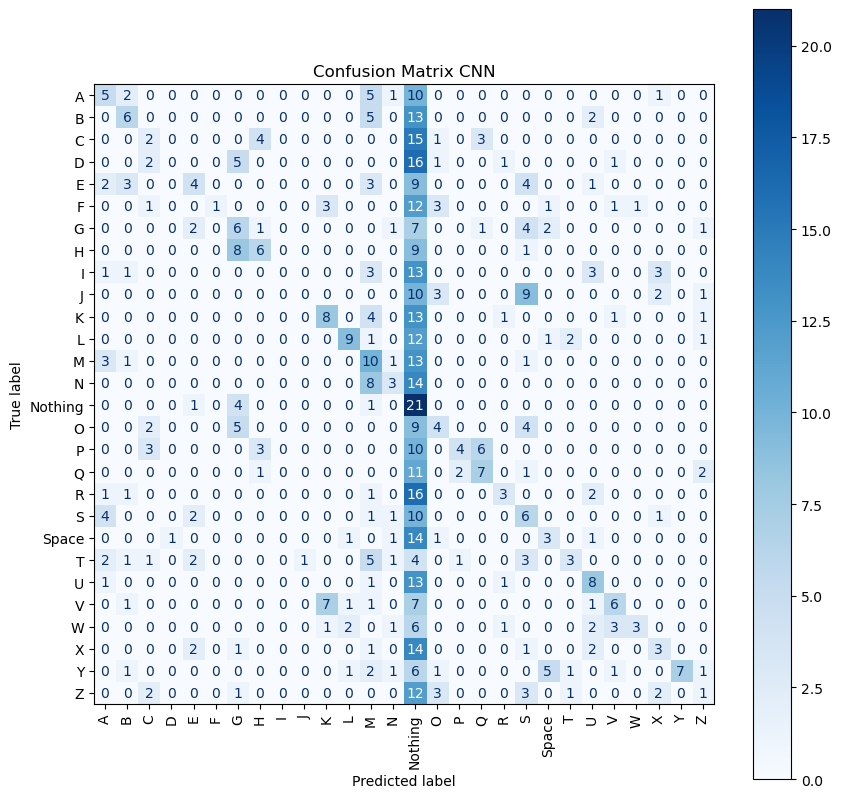

In [24]:
predictions, targets = cnn_results
show_confusion_matrix(targets, predictions, title="Confusion Matrix CNN")

wandb:   1 of 1 files downloaded.  
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.166906476020813
        test_loss            4.544436931610107
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.16691
test_loss,4.54444
trainer/global_step,0


(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix CNN'}, xlabel='Predicted label', ylabel='True label'>)

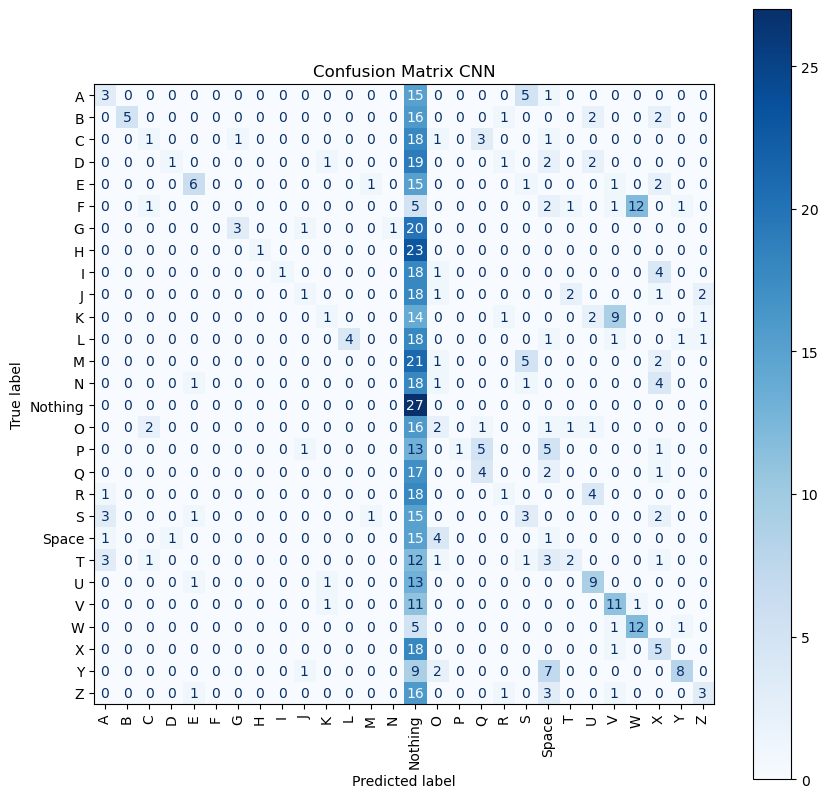

In [20]:
cnn_results_2 = evaluation()
predictions, targets = cnn_results_2
show_confusion_matrix(targets, predictions, title="Confusion Matrix CNN")

In [18]:
evaluation() # Without our own pictures

wandb:   1 of 1 files downloaded.  
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9642857313156128
        test_loss           0.08273524045944214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.96429
test_loss,0.08274
trainer/global_step,0
